In [1]:
from __future__ import print_function 
import os, sys, h5py
import numpy as np
from six.moves import cPickle
from collections import OrderedDict

import tensorflow as tf
sys.path.append('..')
from tfomics import neuralnetwork as nn
from tfomics import utils, fit, init, visualize, saliency
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def load_simulation(filepath):
    # setup paths for file handling

    trainmat = h5py.File(filepath, 'r')

    print("loading training data")
    X_train = np.array(trainmat['X_train']).astype(np.float32)
    y_train = np.array(trainmat['Y_train']).astype(np.float32)

    print("loading cross-validation data")
    X_valid = np.array(trainmat['X_valid']).astype(np.float32)
    y_valid = np.array(trainmat['Y_valid']).astype(np.int32)

    print("loading test data")
    X_test = np.array(trainmat['X_test']).astype(np.float32)
    y_test = np.array(trainmat['Y_test']).astype(np.int32)


    X_train = np.expand_dims(X_train, axis=3).transpose([0,2,3,1])
    X_valid = np.expand_dims(X_valid, axis=3).transpose([0,2,3,1])
    X_test = np.expand_dims(X_test, axis=3).transpose([0,2,3,1])

    return X_train, y_train, X_valid, y_valid, X_test, y_test


# load data
filename = 'Synthetic_TF_dataset_20000.h5'
data_path = '/Users/juliankimura/Desktop/representation learning/data/synthetic_TF_dataset'
filepath = os.path.join(data_path, filename)
X_train, y_train, X_valid, y_valid, X_test, y_test = load_simulation(filepath)



loading training data
loading cross-validation data
loading test data


In [7]:

def model(input_shape, output_shape):

    # create model
    layer1 = {'layer': 'input',
            'input_shape': input_shape
            }
    layer2 = {'layer': 'conv1d', 
            'num_filters': 32,
            'filter_size': 11,
            'norm': 'batch',
            'activation': 'relu',
            'dropout': 0.1,
            'padding': 'SAME',
            'pool_size': 50,
            }
    layer3 = {'layer': 'dense', 
            'num_units': 48,
            'norm': 'batch',
            'activation': 'relu',
            'dropout': 0.5
            }  
    layer4 = {'layer': 'dense', 
            'num_units': output_shape[1],
            'activation': 'sigmoid'
            }

    #from tfomics import build_network
    model_layers = [layer1, layer2, layer3, layer4]
    
    # optimization parameters
    optimization = {"objective": "binary",
                  "optimizer": "adam",
                  "learning_rate": 0.001, 
                  "l2": 1e-6,
                  #"l1": 0.1, 
                  }
    return model_layers, optimization


# get shapes
num_data, height, width, dim = X_train.shape
input_shape=[None, height, width, dim]
output_shape = y_train.shape

model_layers, optimization = model(input_shape, output_shape)

In [8]:
# set output file paths
results_path = utils.make_directory(data_path, 'results')
results_path = utils.make_directory(results_path, 'tfomics')
output_name = 'test'
filepath = os.path.join(results_path, output_name)

# build neural network class
nnmodel = nn.NeuralNet()
nnmodel.build_layers(model_layers, optimization)
# nnmodel.inspect_layers()

# compile neural trainer
nntrainer = nn.NeuralTrainer(nnmodel, save='best', filepath=filepath)

----------------------------------------------------------------------------
Network architecture:
----------------------------------------------------------------------------
layer1: inputs
(?, 200, 1, 4)
layer2: conv1d_0
(?, 200, 1, 32)
layer3: conv1d_0_batch
(?, 200, 1, 32)
layer4: conv1d_0_active
(?, 200, 1, 32)
layer5: conv1d_0_pool
(?, 4, 1, 32)
layer6: conv1d_0_dropout
(?, 4, 1, 32)
layer7: dense_0
(?, 48)
layer8: dense_0_batch
(?, 48)
layer9: dense_0_active
(?, 48)
layer10: dense_0_dropout
(?, 48)
layer11: dense_1
(?, 1)
layer12: dense_1_bias
(?, 1)
layer13: output
(?, 1)
----------------------------------------------------------------------------


In [ ]:
sess = utils.initialize_session(nnmodel.placeholders)

In [ ]:
train = {'inputs': X_train, 'targets': y_train}
valid = {'inputs': X_valid, 'targets': y_valid}
test = {'inputs': X_test, 'targets': y_test}
data = {'train': train, 'valid': valid, 'test': test}
fit.train_minibatch(sess, nntrainer, data, batch_size=200, num_epochs=50, 
                      patience=20, verbose=2, shuffle=True, save_all=False)

Epoch 1 out of 50 
[==============================] 100.0% -- time=0s -- loss=70.76401 -- accuracy=49.93%   
  valid loss:		49.66067
  valid accuracy:	0.48633+/-0.00000
  valid auc-roc:	0.50616+/-0.00000
  valid auc-pr:		0.49256+/-0.00000
  lower cross-validation found
  saving model to:  /Users/juliankimura/Desktop/representation learning/data/synthetic_TF_dataset/results/tfomics/test_best.ckpt
Epoch 2 out of 50 
[==============================] 100.0% -- time=0s -- loss=33.68087 -- accuracy=50.09%   
  valid loss:		20.08516
  valid accuracy:	0.51267+/-0.00000
  valid auc-roc:	0.45763+/-0.00000
  valid auc-pr:		0.46463+/-0.00000
  lower cross-validation found
  saving model to:  /Users/juliankimura/Desktop/representation learning/data/synthetic_TF_dataset/results/tfomics/test_best.ckpt
Epoch 3 out of 50 
[=========                     ] 31.4% -- time=2s -- loss=17.12054 -- accuracy=50.61%  

In [6]:
nntrainer.set_best_parameters(sess)

test = {'inputs': X_test, 'targets': y_test}
loss, mean_vals, std_vals = nntrainer.test_model(sess, test, batch_size=128, name='test', verbose=1)

loading model from:  /Users/juliankimura/Desktop/representation learning/data/synthetic_TF_dataset/results/tfomics/test_best.ckpt
  test  loss:		0.14344
  test  accuracy:	0.94500+/-0.00000
  test  auc-roc:	0.98697+/-0.00000
  test  auc-pr:		0.98506+/-0.00000


/Users/juliankimura/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


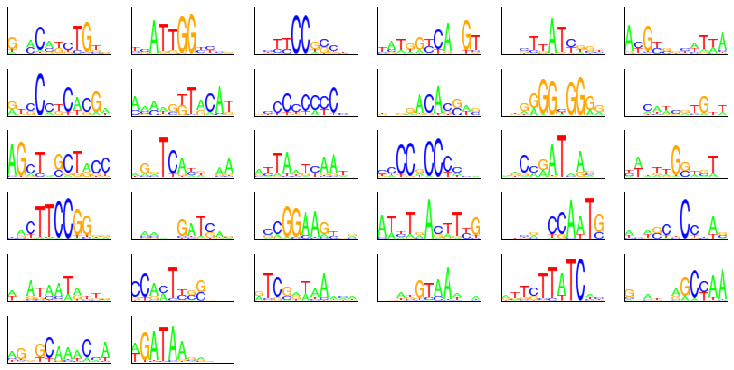

In [7]:
W = nnmodel.get_parameters(sess, layer='conv1d_0')[0]
W = np.squeeze(W.transpose([3, 2, 0, 1]))
fig, plt = visualize.plot_filter_logos(W, normalize=True, figsize=(100,50), height=25, 
                            nt_width=10, norm=0, alphabet='dna')

(-0.5, 3999.5, 99.5, -0.5)

/Users/juliankimura/anaconda/lib/python3.5/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


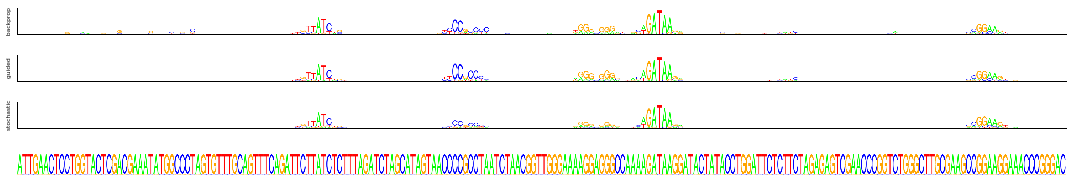

In [9]:
# sequence to perform saliency analysis
index = 1
X = np.expand_dims(X_test[index], axis=0)

# parameters for saliency analysis
params = {'genome_model': model, 
          'input_shape': input_shape, 
          'output_shape': output_shape, 
          'model_path': filepath+'_best.ckpt',
          'optimization': optimization
         }

# backprop saliency
backprop_saliency = saliency.backprop(X, layer='output', class_index=0, params=params)

# guided backprop saliency
guided_saliency = saliency.guided_backprop(X, layer='output', class_index=0, params=params)

# stochastic guided backprop saliency
stochastic_saliency = saliency.stochastic_guided_backprop(X, layer='output', class_index=0, params=params,
                                                         num_average=200, threshold=12.0, stochastic_val=0.5)

# plot saliency comparison
fig, ax = plt.subplots(nrows=4, ncols=1, sharex=True, sharey=True, figsize=(15, 3));
plt.subplot(4,1,1)
visualize.plot_pos_saliency(np.squeeze(backprop_saliency[0]).T)    
plt.ylabel(' backprop', fontsize=6)
plt.subplot(4,1,2)
visualize.plot_pos_saliency(np.squeeze(guided_saliency[0]).T)    
plt.ylabel(' guided', fontsize=6)
plt.subplot(4,1,3)
visualize.plot_pos_saliency(np.squeeze(stochastic_saliency[0]).T)    
plt.ylabel(' stochastic', fontsize=6)
plt.subplot(4,1,4)
visualize.plot_pos_saliency(np.squeeze(X).T)    
plt.axis('off')